In [1]:
import sys
sys.path.append('../')
import deepbayesHF
import deepbayesHF.optimizers as optimizers
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train/255.
X_test = X_test/255.
X_train = X_train.astype("float32").reshape(-1, 28*28)
X_test = X_test.astype("float32").reshape(-1, 28* 28)

In [3]:
model = Sequential()
model.add(Dense(16, activation="relu", input_shape=(None, 28*28)))
model.add(Dense(10, activation="softmax"))
loss = tf.keras.losses.SparseCategoricalCrossentropy()

2022-05-31 23:32:41.692837: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [4]:
"""
learning_rate = 0.35; decay=0.0
opt = optimizers.VariationalOnlineGuassNewton()
bayes_model = opt.compile(model, loss_fn=loss, epochs=10, learning_rate=learning_rate, batch_size=128,
                         robust_train=1, epsilon=0.05, robust_lam = 0.5)
bayes_model.train(X_train, y_train, X_test, y_test)
"""

'\nlearning_rate = 0.35; decay=0.0\nopt = optimizers.VariationalOnlineGuassNewton()\nbayes_model = opt.compile(model, loss_fn=loss, epochs=10, learning_rate=learning_rate, batch_size=128,\n                         robust_train=1, epsilon=0.05, robust_lam = 0.5)\nbayes_model.train(X_train, y_train, X_test, y_test)\n'

In [5]:
#bayes_model.save("PosteriorModels/VOGN_MNIST_Posterior")

In [6]:
from deepbayesHF import PosteriorModel

bayes_model = PosteriorModel("PosteriorModels/VOGN_MNIST_Posterior")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, None, 16)          12560     
                                                                 
 dense_1 (Dense)             (None, None, 10)          170       
                                                                 
Total params: 12,730
Trainable params: 12,730
Non-trainable params: 0
_________________________________________________________________
BayesKeras detected the above model 
 None


In [7]:
y_pred = bayes_model.predict(X_test)

In [8]:
import numpy as np
from tqdm import trange
from deepbayesHF.analyzers import FGSM
y_cls = np.argmax(y_pred, axis=1)
corr = 0
for i in trange(len(y_cls)):
    corr += int(y_cls[i] == y_test[i])
print("Test set accuracy: ", corr/10000)

100%|████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 893793.34it/s]

Test set accuracy:  0.923


In [9]:
from tqdm import trange
import random
INDEX = 7
EPSILON = 0.025
bayes_model.input_lower = 0; bayes_model.input_upper = 1.0
confs = []
for i in trange(1000):
    eps = random.uniform(0, EPSILON)
    x_adv = FGSM(bayes_model, np.asarray([X_test[INDEX]]), loss, eps, direction=-1, num_models=1, order=1, samples=1)
    bayes_model.model.set_weights(bayes_model.sample())
    y = bayes_model._predict(np.asarray([x_adv]))
    confs.append(np.max(y))

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:26<00:00,  6.80it/s]


In [10]:
print(confs)

[0.8957949, 0.890173, 0.8780004, 0.89692694, 0.91322666, 0.8981981, 0.90744376, 0.9073955, 0.901563, 0.8938379, 0.90589815, 0.87812936, 0.89987993, 0.90613633, 0.9079154, 0.8904287, 0.8895761, 0.88796455, 0.9030556, 0.8854288, 0.8932656, 0.9087767, 0.88815475, 0.89570904, 0.896728, 0.87961763, 0.88535446, 0.8906335, 0.9126067, 0.8810571, 0.88052505, 0.8940817, 0.90392584, 0.9102693, 0.8837174, 0.8812019, 0.89462644, 0.91107845, 0.8923232, 0.8910642, 0.89286333, 0.908486, 0.9068244, 0.8847722, 0.8907701, 0.9037632, 0.88729805, 0.9027646, 0.8885512, 0.90431815, 0.89588726, 0.9120633, 0.89379936, 0.885714, 0.90493745, 0.89280087, 0.89997715, 0.91330266, 0.88333476, 0.8950895, 0.88785523, 0.91058713, 0.9025485, 0.88055694, 0.88171506, 0.9089456, 0.9082802, 0.9067586, 0.913571, 0.89535713, 0.9023418, 0.89584374, 0.9087265, 0.90272015, 0.89465773, 0.89895344, 0.9047273, 0.90782166, 0.8831708, 0.8942015, 0.9061215, 0.9047548, 0.8875113, 0.9112933, 0.9058646, 0.9018435, 0.90121853, 0.9121222, 

In [11]:
from deepbayesHF.analyzers import decision_veri

def predicate_safe(iml, imu, ol, ou):
    return True

def logit_value(iml, imu, ol, ou):
    v1 = tf.one_hot(TRUE_VALUE, depth=10)
    v2 = 1 - tf.one_hot(TRUE_VALUE, depth=10)
    v1 = tf.squeeze(v1); v2 = tf.squeeze(v2)
    worst_case = tf.math.add(tf.math.multiply(v2, ou), tf.math.multiply(v1, ol))
    worst_case = tf.nn.softmax(worst_case)
    return worst_case[TRUE_VALUE]



In [12]:

TRUE_VALUE = y_test[INDEX]
MARGIN = 3.0
SAMPLES = 3
MAXDEPTH = 3
img = np.asarray([X_test[INDEX]])
img_upper = np.clip(np.asarray([X_test[INDEX]+(EPSILON)]), 0, 1)
img_lower = np.clip(np.asarray([X_test[INDEX]-(EPSILON)]), 0, 1)
p_lower = decision_veri(bayes_model, img_lower, img_upper, MARGIN, SAMPLES,
                        predicate=predicate_safe, value=logit_value, depth=MAXDEPTH)
  
print("Final Bound: ", p_lower)
    

Checking Samples: 100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 106.18it/s]


--  tf.Tensor(0.86454904, shape=(), dtype=float32)
--  tf.Tensor(0.86443627, shape=(), dtype=float32)
--  tf.Tensor(0.86444074, shape=(), dtype=float32)
Found 3 safe intervals
About to compute intersection for this many intervals:  3
GOT THIS MANY VALUES:  3 [0.86454904 0.86443627 0.86444074]


Computing intersection weights:   0%|                                                                            | 0/3 [00:00<?, ?it/s]/home/matker/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
Computing intersection weights: 100%|██████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 3051.14it/s]

Depth 1 has 3 intersections



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.78s/it]

[0.7170084146826734, 0.795005585991008, 0.8053449289947837] [0.86454904 0.86443627 0.86444074]
Depth 1 prob:  2.317358929668465 logit val:  2.0032935652845905
Depth 2 has 3 intersections



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.51s/it]

Current prob:  0.5239842636501284  Current dec:  0.45290282368337254
Depth 3 has 1 intersections



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.84s/it]

Current prob:  0.9873395407637687  Current dec:  0.8534460019227722
Got this p approx:  0.9873395407637687
Got this d approx:  0.8534460019227722
Final Bound:  0.8426409836051044


In [13]:
from deepbayesHF.analyzers import decision_veri_upper


def logit_value(iml, imu, ol, ou):
    v1 = tf.one_hot(TRUE_VALUE, depth=10)
    v2 = 1 - tf.one_hot(TRUE_VALUE, depth=10)
    v1 = tf.squeeze(v1); v2 = tf.squeeze(v2)
    best_case = tf.math.add(tf.math.multiply(v1, ou), tf.math.multiply(v2, ol))
    best_case = tf.nn.softmax(best_case)
    print("Best Case: ", best_case[TRUE_VALUE])
    return best_case[TRUE_VALUE]


p_upper = decision_veri_upper(bayes_model, img_lower, img_upper, MARGIN, SAMPLES,
                        predicate=predicate_safe, value=logit_value, depth=MAXDEPTH)

    
print("Final Bound: ", p_upper)

Checking Samples:  33%|███████████████████████████▎                                                      | 1/3 [00:00<00:01,  1.27it/s]

Best Case:  tf.Tensor(0.939976, shape=(), dtype=float32)


Checking Samples:  67%|██████████████████████████████████████████████████████▋                           | 2/3 [00:01<00:00,  1.28it/s]

Best Case:  tf.Tensor(0.93998176, shape=(), dtype=float32)


Checking Samples: 100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.28it/s]


Best Case:  tf.Tensor(0.939805, shape=(), dtype=float32)
Found 3 safe intervals
About to compute intersection for this many intervals:  3
GOT THIS MANY VALUES:  3 [<tf.Tensor: shape=(), dtype=float32, numpy=0.939976>, <tf.Tensor: shape=(), dtype=float32, numpy=0.93998176>, <tf.Tensor: shape=(), dtype=float32, numpy=0.939805>]


Computing intersection weights: 100%|█████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 31457.28it/s]

Depth 1 has 3 intersections



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.79s/it]


[0.7759746453080897, 0.7619478427480358, 0.799197764714877] [<tf.Tensor: shape=(), dtype=float32, numpy=0.939976>, <tf.Tensor: shape=(), dtype=float32, numpy=0.93998176>, <tf.Tensor: shape=(), dtype=float32, numpy=0.939805>]
Depth 1 prob:  2.3371202527710024 logit val:  2.1967046307562583
Depth 2 has 3 intersections


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.31s/it]

Current prob:  0.5119837168566472  Current dec:  0.48111300434122994
Depth 3 has 1 intersections



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.09s/it]

Current prob:  0.9881396086916643  Current dec:  0.9286066785625712
Got this p approx:  0.9881396086916643
Got this d approx:  0.9286066785625712
Final Bound:  0.9294534312916208


(0.8, 0.95)

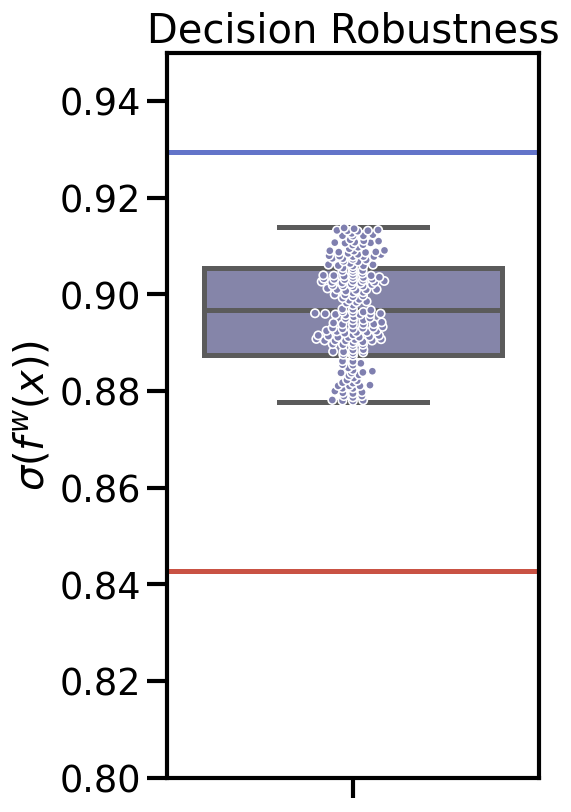

In [14]:
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')

plt.figure(figsize=(4, 8), dpi=120)

sns.boxplot(y=confs, color='#7f7faf')
plt.title('Decision Robustness')
plt.ylabel(r'$\sigma(f^{w}(x))$')
sns.swarmplot(y=confs[0:200], linewidth=1, edgecolor='w', color='#7f7faf')
plt.axhline(y=p_upper, color='#6374c9', linestyle='-')
plt.axhline(y=p_lower, color='#c95244', linestyle='-')
plt.ylim((0.8, 0.95))

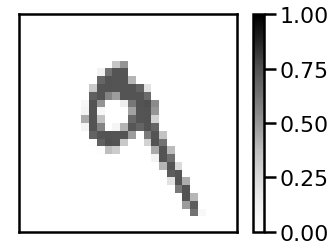

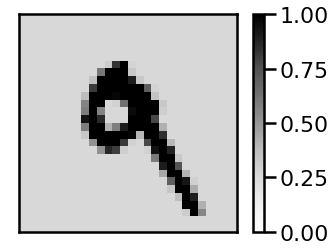

In [15]:
plt.imshow(np.clip(X_test[INDEX].reshape(28,28)-0.25, 0, 1), cmap='Greys')
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
c = plt.colorbar()
plt.clim(0.0, 1.0) 
plt.show()

plt.imshow(np.clip(X_test[INDEX].reshape(28,28)+0.25, 0, 1), cmap='Greys')
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
c = plt.colorbar()
plt.clim(0.0, 1.0) 
plt.show()

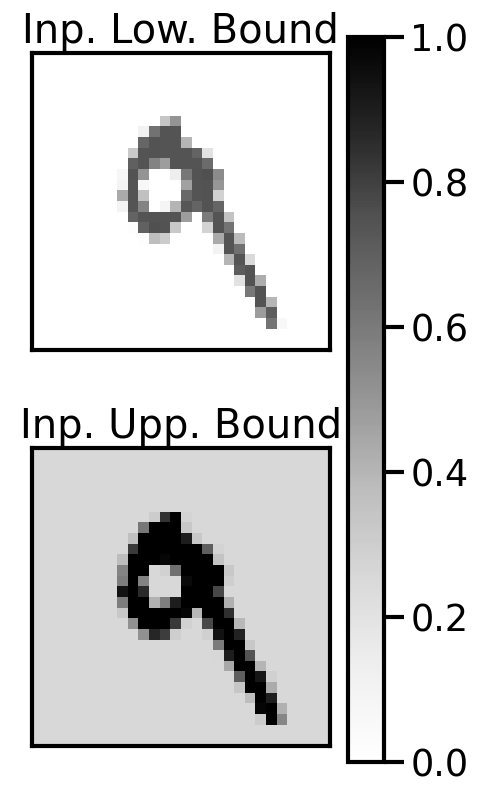

In [59]:
import numpy as np
import matplotlib.pyplot as plt
#plt.figure(figsize=(4, 8), dpi=120)
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(4, 8), dpi=120)
i = 0
for ax in axes.flat:
    if(i == 0):
        ax.set_title('Inp. Low. Bound')
        im = ax.imshow(np.clip(X_test[INDEX].reshape(28,28)-0.25, 0, 1), cmap='Greys')
        i+=1
    else:
        ax.set_title('Inp. Upp. Bound')
        im = ax.imshow(np.clip(X_test[INDEX].reshape(28,28)+0.25, 0, 1), cmap='Greys')
    #im = ax.imshow(np.random.random((10,10)), vmin=0, vmax=1)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    #ax.clim(0.0, 1.0)
    im.set_clim(vmin=0, vmax=1)
fig.colorbar(im, ax=axes.ravel().tolist())
#plt.clim(0.0, 1.0)
plt.show()

In [16]:
MSR = []

In [17]:
INDEX = 7
EPSILON = 0.15
bayes_model.input_lower = 0; bayes_model.input_upper = 1.0
for E in trange(35):
    for i in range(5):
        eps = EPSILON + random.uniform(0.1*i, (0.1*(i+1)))
        x_adv = FGSM(bayes_model, np.asarray([X_test[INDEX]]), loss, eps, direction=-1, num_models=1, order=1, samples=15)
        est = 0
        for j in range(100):
            bayes_model.model.set_weights(bayes_model.sample())
            y = bayes_model._predict(np.asarray([x_adv]))
            if(np.argmax(y) == TRUE_VALUE):
                est += 1
            if(est > 51):
                break
        if(j == 99):
            print(eps, est)
            MSR.append(eps)
            break

  3%|██▊                                                                                                | 1/35 [00:03<01:46,  3.12s/it]

0.32304437780297457 0


  6%|█████▋                                                                                             | 2/35 [00:07<02:07,  3.85s/it]

0.41723883863250244 0


  9%|████████▍                                                                                          | 3/35 [00:11<02:10,  4.08s/it]

0.4431045753154692 0


 11%|███████████▎                                                                                       | 4/35 [00:16<02:09,  4.19s/it]

0.37663107759287573 0


 14%|██████████████▏                                                                                    | 5/35 [00:20<02:07,  4.25s/it]

0.39203940800468484 0


 17%|████████████████▉                                                                                  | 6/35 [00:23<01:50,  3.80s/it]

0.3414261425120907 0


 20%|███████████████████▊                                                                               | 7/35 [00:27<01:51,  3.98s/it]

0.44293873554058494 0


 23%|██████████████████████▋                                                                            | 8/35 [00:32<01:50,  4.10s/it]

0.41382976061866616 0


 26%|█████████████████████████▍                                                                         | 9/35 [00:35<01:37,  3.74s/it]

0.30871490122702105 0


 29%|████████████████████████████                                                                      | 10/35 [00:38<01:28,  3.54s/it]

0.3486829471948588 0


 31%|██████████████████████████████▊                                                                   | 11/35 [00:42<01:30,  3.79s/it]

0.41784551495565814 0


 34%|█████████████████████████████████▌                                                                | 12/35 [00:45<01:21,  3.53s/it]

0.34734587305939923 0


 37%|████████████████████████████████████▍                                                             | 13/35 [00:49<01:23,  3.78s/it]

0.4223750698279919 0


 40%|███████████████████████████████████████▏                                                          | 14/35 [00:52<01:14,  3.53s/it]

0.29783895928879156 0


 43%|██████████████████████████████████████████                                                        | 15/35 [00:57<01:15,  3.78s/it]

0.37492872255727033 0


 46%|████████████████████████████████████████████▊                                                     | 16/35 [01:00<01:07,  3.53s/it]

0.3388225904523559 0


 49%|███████████████████████████████████████████████▌                                                  | 17/35 [01:04<01:08,  3.78s/it]

0.440265338332407 0


 51%|██████████████████████████████████████████████████▍                                               | 18/35 [01:07<01:00,  3.54s/it]

0.33512730637345317 0


 54%|█████████████████████████████████████████████████████▏                                            | 19/35 [01:10<00:53,  3.36s/it]

0.3253510780255975 0


 57%|████████████████████████████████████████████████████████                                          | 20/35 [01:14<00:54,  3.65s/it]

0.443963132476596 0


 60%|██████████████████████████████████████████████████████████▊                                       | 21/35 [01:17<00:48,  3.44s/it]

0.3106612561775193 0


 63%|█████████████████████████████████████████████████████████████▌                                    | 22/35 [01:20<00:42,  3.29s/it]

0.2917546589663804 0


 66%|████████████████████████████████████████████████████████████████▍                                 | 23/35 [01:24<00:43,  3.61s/it]

0.37951103374227935 0


 69%|███████████████████████████████████████████████████████████████████▏                              | 24/35 [01:27<00:37,  3.41s/it]

0.3487485642901116 0


 71%|██████████████████████████████████████████████████████████████████████                            | 25/35 [01:32<00:36,  3.69s/it]

0.3783834883611809 0


 74%|████████████████████████████████████████████████████████████████████████▊                         | 26/35 [01:36<00:35,  3.89s/it]

0.4127591251907853 0


 77%|███████████████████████████████████████████████████████████████████████████▌                      | 27/35 [01:39<00:29,  3.65s/it]

0.3291971694486605 0


 80%|██████████████████████████████████████████████████████████████████████████████▍                   | 28/35 [01:42<00:24,  3.44s/it]

0.32623802894778664 0


 83%|█████████████████████████████████████████████████████████████████████████████████▏                | 29/35 [01:47<00:22,  3.71s/it]

0.3590944146043891 0


 86%|████████████████████████████████████████████████████████████████████████████████████              | 30/35 [01:49<00:17,  3.48s/it]

0.2946937096343874 0


 89%|██████████████████████████████████████████████████████████████████████████████████████▊           | 31/35 [01:52<00:13,  3.32s/it]

0.3009180933003459 0


 91%|█████████████████████████████████████████████████████████████████████████████████████████▌        | 32/35 [01:57<00:10,  3.63s/it]

0.41536289933258563 0


 94%|████████████████████████████████████████████████████████████████████████████████████████████▍     | 33/35 [02:00<00:06,  3.42s/it]

0.30719312077656113 0


 97%|███████████████████████████████████████████████████████████████████████████████████████████████▏  | 34/35 [02:04<00:03,  3.70s/it]

0.3808498644019034 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [02:08<00:00,  3.68s/it]

0.43443980021564377 0


In [18]:
print(MSR)

[0.32304437780297457, 0.41723883863250244, 0.4431045753154692, 0.37663107759287573, 0.39203940800468484, 0.3414261425120907, 0.44293873554058494, 0.41382976061866616, 0.30871490122702105, 0.3486829471948588, 0.41784551495565814, 0.34734587305939923, 0.4223750698279919, 0.29783895928879156, 0.37492872255727033, 0.3388225904523559, 0.440265338332407, 0.33512730637345317, 0.3253510780255975, 0.443963132476596, 0.3106612561775193, 0.2917546589663804, 0.37951103374227935, 0.3487485642901116, 0.3783834883611809, 0.4127591251907853, 0.3291971694486605, 0.32623802894778664, 0.3590944146043891, 0.2946937096343874, 0.3009180933003459, 0.41536289933258563, 0.30719312077656113, 0.3808498644019034, 0.43443980021564377]


In [19]:
from deepbayesHF.analyzers import prob_veri 

MARGIN = 2.0
SAMPLES = 3
def predicate_safe(iml, imu, ol, ou):
    v1 = tf.one_hot(TRUE_VALUE, depth=10)
    v2 = 1 - tf.one_hot(TRUE_VALUE, depth=10)
    v1 = tf.squeeze(v1); v2 = tf.squeeze(v2)
    worst_case = tf.math.add(tf.math.multiply(v2, ou), tf.math.multiply(v1, ol))
    if(np.argmax(worst_case) == TRUE_VALUE):
        return True
    else:
        return False

lowers = []
epsilons = [0.1, 0.25, 0.5, 0.75, 1.0]
for EPSILON in epsilons:
    img = np.asarray([X_test[INDEX]])
    img_upper = np.clip(np.asarray([X_test[INDEX]+(EPSILON)]), 0, 1)
    img_lower = np.clip(np.asarray([X_test[INDEX]-(EPSILON)]), 0, 1)
    p_lower = prob_veri(bayes_model, img_lower, img_upper, MARGIN, SAMPLES, predicate=predicate_safe, depth=MAXDEPTH)
    lowers.append(p_lower)

Checking Samples: 100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 168.56it/s]


Found 0 safe intervals
About to compute intersection for this many intervals:  0


Computing intersection weights: 0it [00:00, ?it/s]

Depth 1 has 0 intersections



0it [00:00, ?it/s]

Depth 1 prob:  0
Depth 2 has 0 intersections



0it [00:00, ?it/s]

Depth 2 prob: 0
Current approximation: 0
Depth 2 prob::  0
Depth 3 has 0 intersections



0it [00:00, ?it/s]


Depth 3 prob: 0
Current approximation: 0
Got this approximation:  0


Checking Samples: 100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 101.39it/s]


Found 0 safe intervals
About to compute intersection for this many intervals:  0


Computing intersection weights: 0it [00:00, ?it/s]

Depth 1 has 0 intersections



0it [00:00, ?it/s]

Depth 1 prob:  0
Depth 2 has 0 intersections



0it [00:00, ?it/s]

Depth 2 prob: 0
Current approximation: 0
Depth 2 prob::  0
Depth 3 has 0 intersections



0it [00:00, ?it/s]


Depth 3 prob: 0
Current approximation: 0
Got this approximation:  0


Checking Samples: 100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 104.34it/s]


Found 0 safe intervals
About to compute intersection for this many intervals:  0


Computing intersection weights: 0it [00:00, ?it/s]

Depth 1 has 0 intersections



0it [00:00, ?it/s]

Depth 1 prob:  0
Depth 2 has 0 intersections



0it [00:00, ?it/s]

Depth 2 prob: 0
Current approximation: 0
Depth 2 prob::  0
Depth 3 has 0 intersections



0it [00:00, ?it/s]


Depth 3 prob: 0
Current approximation: 0
Got this approximation:  0


Checking Samples: 100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 176.20it/s]


Found 0 safe intervals
About to compute intersection for this many intervals:  0


Computing intersection weights: 0it [00:00, ?it/s]

Depth 1 has 0 intersections



0it [00:00, ?it/s]

Depth 1 prob:  0
Depth 2 has 0 intersections



0it [00:00, ?it/s]

Depth 2 prob: 0
Current approximation: 0
Depth 2 prob::  0
Depth 3 has 0 intersections



0it [00:00, ?it/s]


Depth 3 prob: 0
Current approximation: 0
Got this approximation:  0


Checking Samples: 100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 203.46it/s]


Found 0 safe intervals
About to compute intersection for this many intervals:  0


Computing intersection weights: 0it [00:00, ?it/s]

Depth 1 has 0 intersections



0it [00:00, ?it/s]

Depth 1 prob:  0
Depth 2 has 0 intersections



0it [00:00, ?it/s]

Depth 2 prob: 0
Current approximation: 0
Depth 2 prob::  0
Depth 3 has 0 intersections



0it [00:00, ?it/s]

Depth 3 prob: 0
Current approximation: 0
Got this approximation:  0


In [21]:
from deepbayesHF.analyzers import prob_veri_upper 

def predicate_unsafe(iml, imu, ol, ou):
    v1 = tf.one_hot(TRUE_VALUE, depth=10)
    v2 = 1 - tf.one_hot(TRUE_VALUE, depth=10)
    v1 = tf.squeeze(v1); v2 = tf.squeeze(v2)
    #worst_case = tf.math.add(tf.math.multiply(v2, ou), tf.math.multiply(v1, ol))
    best_case = tf.math.add(tf.math.multiply(v1, ou), tf.math.multiply(v2, ol))
    if(np.argmax(best_case) == TRUE_VALUE):
        return False
    else:
        return True

uppers = []
epsilons = [0.1]
for EPSILON in epsilons:
    img = np.asarray([X_test[INDEX]])
    img_upper = np.clip(np.asarray([X_test[INDEX]+(EPSILON)]), 0, 1)
    img_lower = np.clip(np.asarray([X_test[INDEX]-(EPSILON)]), 0, 1)
    p_upper = prob_veri_upper(bayes_model, img_lower, img_upper, MARGIN, SAMPLES, predicate=predicate_unsafe, depth=MAXDEPTH)
    p_upper = 1-p_upper
    uppers.append(p_upper)



Checking Samples: 100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.20s/it]


Found 0 safe intervals
About to compute intersection for this many intervals:  0


Computing intersection weights: 0it [00:00, ?it/s]

Depth 1 has 0 intersections



0it [00:00, ?it/s]

Depth 1 prob:  0
Depth 2 has 0 intersections



0it [00:00, ?it/s]

Depth 2 prob: 0
Current approximation: 0
Depth 2 prob::  0
Depth 3 has 0 intersections



0it [00:00, ?it/s]

Depth 3 prob: 0
Current approximation: 0
Got this approximation:  0


In [ ]:
print([round(i, 2) for i in uppers])
print([round(i, 2) for i in lowers])

In [28]:
EPSILON = 0.09
img = np.asarray([X_test[INDEX]])
img_upper = np.clip(np.asarray([X_test[INDEX]+(EPSILON)]), 0, 1)
img_lower = np.clip(np.asarray([X_test[INDEX]-(EPSILON)]), 0, 1)
p_lower = prob_veri(bayes_model, img_lower, img_upper, 2.5, 100, predicate=predicate_safe, depth=1)
lowers.append(p_lower)

Checking Samples: 100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.48it/s]


Found 100 safe intervals
About to compute intersection for this many intervals:  100


Computing intersection weights: 100%|█████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 38879.35it/s]

Depth 1 has 100 intersections



  0%|                                                                                                          | 0/100 [00:12<?, ?it/s]Process ForkPoolWorker-1575:
Process ForkPoolWorker-1591:
Process ForkPoolWorker-1583:
Process ForkPoolWorker-1569:
Process ForkPoolWorker-1572:
Process ForkPoolWorker-1579:
Process ForkPoolWorker-1589:
Process ForkPoolWorker-1576:

Process ForkPoolWorker-1577:
Process ForkPoolWorker-1573:


KeyboardInterrupt: 

Process ForkPoolWorker-1574:
Process ForkPoolWorker-1596:
Process ForkPoolWorker-1580:
Process ForkPoolWorker-1597:
Process ForkPoolWorker-1587:
Process ForkPoolWorker-1582:
Process ForkPoolWorker-1585:
Process ForkPoolWorker-1595:
Process ForkPoolWorker-1578:
Process ForkPoolWorker-1590:
Process ForkPoolWorker-1593:
Process ForkPoolWorker-1581:
Traceback (most recent call last):
Process ForkPoolWorker-1584:
Process ForkPoolWorker-1594:
Process ForkPoolWorker-1570:
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 313, in _bootstrap
    self.run()
Process ForkPoolWorker-1571:
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/multiprocessing/process.py", line 313, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/

  File "/usr/lib/python3.8/multiprocessing/process.py", line 313, in _bootstrap
    self.run()
  File "/home/matker/.local/lib/python3.8/site-packages/tensorflow/python/ops/array_ops.py", line 1029, in _slice_helper
    stack(strides))
  File "../deepbayesHF/analyzers/probverification.py", line 246, in compute_interval_probs_weight_std
    p += compute_erf_prob(interval, means[i][j], var[i][j])
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 313, in _bootstrap
    self.run()
  File "../deepbayesHF/analyzers/probverification.py", line 378, in compute_probability_subroutine
    ps_weight.append(compute_interval_probs_weight_std((dimensionwise_intervals[i], margin, mean[i], np.asarray(var[i]))))
  File "/home/matker/.local/lib/python3.8/site-packages/tensorflow/python/ops/array_ops.py", line 1029, in _slice_helper
    stack(strides))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kw

  File "/home/matker/.local/lib/python3.8/site-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "/home/matker/.local/lib/python3.8/site-packages/tensorflow/python/framework/constant_op.py", line 308, in _constant_eager_impl
    t = convert_to_eager_tensor(value, ctx, dtype)
  File "../deepbayesHF/analyzers/probverification.py", line 187, in compute_erf_prob
    val2 = erf((mean-interval[1])/(math.sqrt(2)*(var)))
  File "/home/matker/.local/lib/python3.8/site-packages/tensorflow/python/ops/array_ops.py", line 1029, in _slice_helper
    stack(strides))
  File "../deepbayesHF/analyzers/probverification.py", line 246, in compute_interval_probs_weight_std
    p += compute_erf_prob(interval, means[i][j], var[i][j])
  File "../deepbayesHF/analyzers/probverification.py", line 246, in compute_interval_probs_weight_std
    p += compute_erf_prob(interval, means[i][j], var[i][j])
  File "/home/matker/.local/lib/python3.8/site-pac

  File "/home/matker/.local/lib/python3.8/site-packages/tensorflow/python/ops/array_ops.py", line 1414, in stack
    return ops.convert_to_tensor(values, name=name)
  File "/home/matker/.local/lib/python3.8/site-packages/tensorflow/python/ops/math_ops.py", line 1566, in truediv
    return _truediv_python3(x, y, name)
  File "/home/matker/.local/lib/python3.8/site-packages/tensorflow/python/ops/math_ops.py", line 1377, in binary_op_wrapper
    with ops.name_scope(None, op_name, [x, y]) as name:
  File "/home/matker/.local/lib/python3.8/site-packages/tensorflow/python/ops/math_ops.py", line 1487, in _truediv_python3
    with ops.name_scope(name, "truediv", [x, y]) as name:
  File "/home/matker/.local/lib/python3.8/site-packages/tensorflow/python/framework/ops.py", line 1621, in convert_to_tensor
    ret = conversion_func(value, dtype=dtype, name=name, as_ref=as_ref)
  File "/home/matker/.local/lib/python3.8/site-packages/tensorflow/python/profiler/trace.py", line 163, in wrapped
    retu

  File "/home/matker/.local/lib/python3.8/site-packages/tensorflow/python/framework/constant_op.py", line 106, in convert_to_eager_tensor
    return ops.EagerTensor(value, ctx.device_name, dtype)
  File "/home/matker/.local/lib/python3.8/site-packages/tensorflow/python/framework/constant_op.py", line 271, in constant
    return _constant_impl(value, dtype, shape, name, verify_shape=False,
  File "/home/matker/.local/lib/python3.8/site-packages/tensorflow/python/framework/constant_op.py", line 106, in convert_to_eager_tensor
    return ops.EagerTensor(value, ctx.device_name, dtype)
KeyboardInterrupt
  File "/home/matker/.local/lib/python3.8/site-packages/tensorflow/python/framework/constant_op.py", line 283, in _constant_impl
    return _constant_eager_impl(ctx, value, dtype, shape, verify_shape)
KeyboardInterrupt
  File "/home/matker/.local/lib/python3.8/site-packages/tensorflow/python/framework/constant_op.py", line 308, in _constant_eager_impl
    t = convert_to_eager_tensor(value, c

  File "../deepbayesHF/analyzers/probverification.py", line 378, in compute_probability_subroutine
    ps_weight.append(compute_interval_probs_weight_std((dimensionwise_intervals[i], margin, mean[i], np.asarray(var[i]))))
  File "../deepbayesHF/analyzers/probverification.py", line 246, in compute_interval_probs_weight_std
    p += compute_erf_prob(interval, means[i][j], var[i][j])
  File "../deepbayesHF/analyzers/probverification.py", line 378, in compute_probability_subroutine
    ps_weight.append(compute_interval_probs_weight_std((dimensionwise_intervals[i], margin, mean[i], np.asarray(var[i]))))
  File "../deepbayesHF/analyzers/probverification.py", line 246, in compute_interval_probs_weight_std
    p += compute_erf_prob(interval, means[i][j], var[i][j])
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "../deepbayesHF/analyzers/probverification.py", line 246, in compute_interval_probs_weight_std
    p += compute

  File "/home/matker/.local/lib/python3.8/site-packages/tensorflow/python/ops/array_ops.py", line 966, in _slice_helper
    tensor = ops.convert_to_tensor(tensor)
  File "/home/matker/.local/lib/python3.8/site-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "/home/matker/.local/lib/python3.8/site-packages/tensorflow/python/ops/array_ops.py", line 1028, in _slice_helper
    packed_begin, packed_end, packed_strides = (stack(begin), stack(end),
  File "/home/matker/.local/lib/python3.8/site-packages/tensorflow/python/ops/math_ops.py", line 1383, in binary_op_wrapper
    return func(x, y, name=name)
  File "/home/matker/.local/lib/python3.8/site-packages/tensorflow/python/ops/math_ops.py", line 1383, in binary_op_wrapper
    return func(x, y, name=name)
  File "/home/matker/.local/lib/python3.8/site-packages/tensorflow/python/ops/array_ops.py", line 1028, in _slice_helper
    packed_begin, packed_end, packed_strides = (s

  File "/home/matker/.local/lib/python3.8/site-packages/tensorflow/python/ops/math_ops.py", line 1488, in _truediv_python3
    x = ops.convert_to_tensor(x, name="x")
  File "/home/matker/.local/lib/python3.8/site-packages/tensorflow/python/ops/math_ops.py", line 1566, in truediv
    return _truediv_python3(x, y, name)
  File "/home/matker/.local/lib/python3.8/site-packages/tensorflow/python/profiler/trace.py", line 163, in wrapped
    return func(*args, **kwargs)
  File "/home/matker/.local/lib/python3.8/site-packages/tensorflow/python/ops/gen_math_ops.py", line 11126, in sub
    _result = pywrap_tfe.TFE_Py_FastPathExecute(
  File "/home/matker/.local/lib/python3.8/site-packages/tensorflow/python/profiler/trace.py", line 163, in wrapped
    return func(*args, **kwargs)
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/home/matker/.local/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py", line 1096, in op_dispatch_handler
    return dispatch_target(*args, **kwa

  File "/home/matker/.local/lib/python3.8/site-packages/tensorflow/python/ops/array_ops.py", line 1015, in _slice_helper
    _check_index(s)
  File "/home/matker/.local/lib/python3.8/site-packages/tensorflow/python/ops/math_ops.py", line 1377, in binary_op_wrapper
    with ops.name_scope(None, op_name, [x, y]) as name:
  File "/home/matker/.local/lib/python3.8/site-packages/tensorflow/python/ops/array_ops.py", line 878, in _check_index
    if isinstance(idx, (numbers.Integral, tensor_shape.Dimension)):
  File "/home/matker/.local/lib/python3.8/site-packages/tensorflow/python/framework/ops.py", line 6638, in name_scope
    if not context.executing_eagerly():
  File "/usr/lib/python3.8/abc.py", line 98, in __instancecheck__
    return _abc_instancecheck(cls, instance)
  File "/home/matker/.local/lib/python3.8/site-packages/tensorflow/python/eager/context.py", line 2084, in executing_eagerly
    return ctx.executing_eagerly()
  File "/usr/lib/python3.8/abc.py", line 100, in __subclasschec

In [45]:
EPSILON = 0.65
img = np.asarray([X_test[INDEX]])
img_upper = np.clip(np.asarray([X_test[INDEX]+(EPSILON)]), 0, 1)
img_lower = np.clip(np.asarray([X_test[INDEX]-(EPSILON)]), 0, 1)
p_lower = prob_veri_upper(bayes_model, img_lower, img_upper, 2.75, 3, predicate=predicate_unsafe, depth=3)
lowers.append(p_lower)

Checking Samples: 100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:10<00:00,  3.41s/it]


Found 3 safe intervals
About to compute intersection for this many intervals:  3


Computing intersection weights: 100%|██████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 7273.36it/s]

Depth 1 has 3 intersections



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:08<00:00,  2.79s/it]

Depth 1 prob:  0.9560563554092866
Depth 2 has 3 intersections



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:10<00:00,  3.54s/it]

Depth 2 prob: -0.3121180095128921
Current approximation: 0.6439383458963945
Depth 2 prob::  0.6439383458963945
Depth 3 has 1 intersections



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.34s/it]

Depth 3 prob: 0.03471557381786752
Current approximation: 0.678653919714262
Got this approximation:  0.678653919714262


In [31]:
print("hello")

hello


(0.0, 1.05)

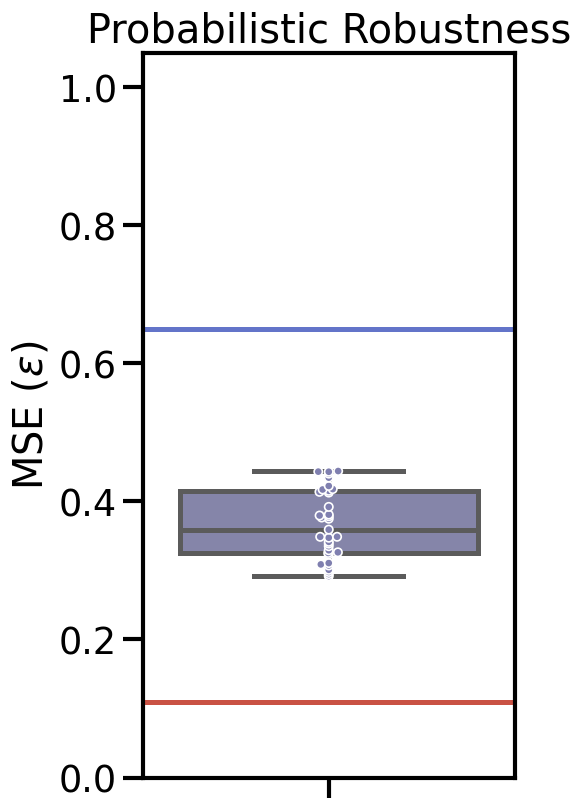

In [47]:
plt.figure(figsize=(4, 8), dpi=120)
plt.title('Probabilistic Robustness')
plt.ylabel(r'MSE ($\epsilon$)')
sns.swarmplot(y=MSR, linewidth=1, edgecolor='w', color='#7f7faf')
sns.boxplot(y=MSR, color='#7f7faf')
plt.axhline(y=0.65, color='#6374c9', linestyle='-')
plt.axhline(y=0.11, color='#c95244', linestyle='-')
plt.ylim((0.0,1.05))